In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")

import os

# transform
import numpy as np
import pandas as pd
from datetime import datetime

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt

# cross validation split
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit

# modeling
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Exercises

> ## **Using saas.csv or log data from API usage**

In [2]:
def get_saas_data():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'saas.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        print(f'Search for it, I am not going to....')
    return df

In [3]:
df = get_saas_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Id,790458.0,1.012913e+06,7591.991578,1000000.0,1006405.00,1012797.0,1019154.00,1029399.0
Invoice_Id,790458.0,5.395228e+06,228185.713880,5000000.0,5197614.25,5395228.5,5592842.75,5790457.0
Subscription_Type,790458.0,5.992349e-01,0.950380,0.0,0.00,0.0,1.00,4.0
Amount,790458.0,2.996174e+00,4.751901,0.0,0.00,0.0,5.00,20.0


In [6]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


## Cleaning up column names

In [7]:
# cleaned up columns names prior to conversion
df.columns = [col.lower() for col in df.columns]
df.head()

,month_invoiced,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [8]:
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [9]:
df = df.set_index('month_invoiced').sort_index()
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


## Dropping unnecessary columns

In [10]:
df.drop(columns=['customer_id', 'invoice_id', 'subscription_type'])

,amount
month_invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0
...,...
2017-12-31,0.0
2017-12-31,0.0
2017-12-31,15.0


In [11]:
df.amount.value_counts() 

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [12]:
# returning date range of data
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

Date Range: 2014-01-31 00:00:00 to 2017-12-31 00:00:00
Shape: (790458, 4)


## **Percentage based split:**


In [13]:
def percent_split(df):
    """
    Splits a DataFrame into training, validation, and test sets based on percentage sizes.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    train (pd.DataFrame): The training set.
    val (pd.DataFrame): The validation set.
    test (pd.DataFrame): The test set.
    """
    # Calculate the sizes of the train, validation, and test sets as percentages of the total length
    train_size = int(len(df) * 0.5)
    val_size = int(len(df) * 0.3)
    test_size = int(len(df) - train_size - val_size)
    val_end_index = train_size + val_size
    
    # Split the DataFrame into train, validation, and test sets
    train = df[:train_size]
    val = df[train_size:val_end_index]
    test = df[val_end_index:]

    return train, val, test

## **Human based split:**

In [14]:
def human_split(df):
    """
    Splits a DataFrame into training, validation, and test sets based on specific date ranges.

    Parameters:
    df (pd.DataFrame): The input DataFrame with a datetime index.

    Returns:
    train (pd.DataFrame): The training set.
    val (pd.DataFrame): The validation set.
    test (pd.DataFrame): The test set.
    """
    # Split the DataFrame into train, validation, and test sets based on specific date ranges
    train = df.loc['2014':'2015']
    val = df.loc['2016']
    test = df.loc['2017']

    return train, val, test

## **Cross Validation based split:** 
### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [15]:
def cv_split(df):
    """
    Splits a time series DataFrame into training, validation, and test sets using TimeSeriesSplit.

    Parameters:
    df (pd.DataFrame): The input time series DataFrame.

    Returns:
    train (pd.DataFrame): The training set.
    val (pd.DataFrame): The validation set.
    test (pd.DataFrame): The test set.
    """

    # Splitting the data into train_val and test sets using TimeSeriesSplit (6 splits)
    for train_val_index, test_index in TimeSeriesSplit(6).split(df):
        
        train_val,test=df.iloc[train_val_index],df.iloc[test_index]

    # Resetting the index and describing the train_val set with datetime_is_numeric=True
    train_val.reset_index().describe(datetime_is_numeric=True)

    # Splitting the train_val data into train and validation sets using TimeSeriesSplit (5 splits)
    for train_index, val_index in TimeSeriesSplit(5).split(train_val):
        
        train,val=train_val.iloc[train_index],train_val.iloc[val_index]

    # Resetting the index and describing the train set with datetime_is_numeric=True
    train.reset_index().describe(datetime_is_numeric=True)
    
    return train, val, test

In [16]:
#-------starified random sampling----------------

# # 5 folds in cross validation; model will be trained on each fold and evaluated on the remaining
# # if data is biggger add more folds; may be computionally expensive
# kfold = StratifiedKFold(n_splits=5)

# # split data into train and validation folds.
# X_train, X_val, y_train, y_val = [], [], [], []
# for train.index ,val.index, in kfold.split(X, y):
#     X_train.append(X[train_index])
#     X_val.ppend(X[val_index])
#     y_train.append(y[train.index])
#     y_val.append(y[val.index])

# ------------------------------------------------

In [17]:
def wrangle_saas():
    """
    Wrangles SAAS data by preprocessing and splitting it into train, validation, and test sets.

    Returns:
    train (pd.DataFrame): The training set.
    val (pd.DataFrame): The validation set.
    test (pd.DataFrame): The test set.
    """
    # Get SAAS data and preprocess it
    df = get_saas_data()
    df.columns = [col.lower() for col in df.columns]
    df.month_invoiced = pd.to_datetime(df.month_invoiced)
    df = df.set_index('month_invoiced').sort_index()
    df['month'] = df.index.month_name()
    df['day_of_week'] = df.index.day_name()
    # df = df.drop(columns=['customer_id', 'invoice_id', 'subscription_type']).resample('m').sum()
    
    # Split the preprocessed data into train, validation, and test sets using cv_split
    train, val, test = human_split(df)

    return train, val, test

# 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

## splitted by calling functions that used cross validation split

In [18]:
train, val, test = wrangle_saas()

train.shape, val.shape, test.shape

((431894, 6), (186275, 6), (172289, 6))

In [19]:
month_train = train.resample('M').amount.sum()
month_val = val.resample('M').amount.sum()
month_test = test.resample('M').amount.sum()

month_train.head()

month_invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: amount, dtype: float64

## plotting each sub set

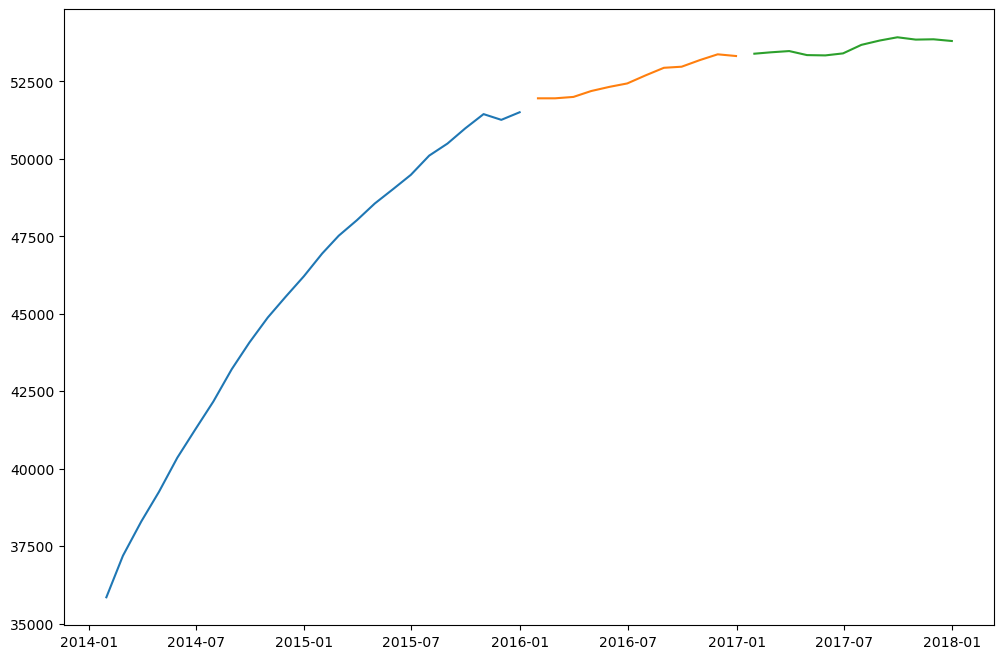

In [20]:
plt.figure(figsize=[12,8])
plt.plot(month_train)
plt.plot(month_val)
plt.plot(month_test)
plt.show()

# 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:

##  Last Observed Value

In [21]:
last_observed_train = train.resample('M').amount.sum()[-1]
last_observed_val = val.resample('M').amount.sum()[-1]
last_observed_test = test.resample('M').amount.sum()[-1]

last_observed_train, last_observed_val, last_observed_test

(51505.0, 53320.0, 53805.0)

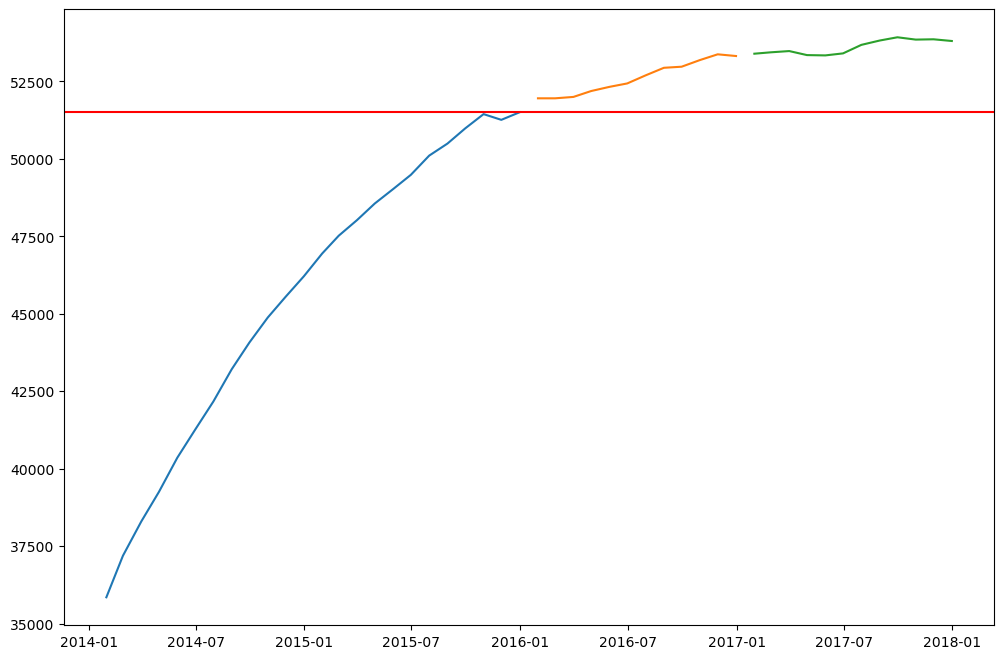

In [22]:
plt.figure(figsize=[12,8])
plt.plot(month_train)
plt.plot(month_val)
plt.plot(month_test)
plt.axhline(y=last_observed_train, color='r')
plt.show()

##  Simple Average

In [23]:
simple_average_train = round(train.resample('M').amount.sum().mean(), 2)
simple_average_val = round(val.resample('M').amount.sum().mean(), 2)
simple_average_test = round(test.resample('M').amount.sum().mean(), 2)

simple_average_train, simple_average_val, simple_average_test

(45568.54, 52612.92, 53612.5)

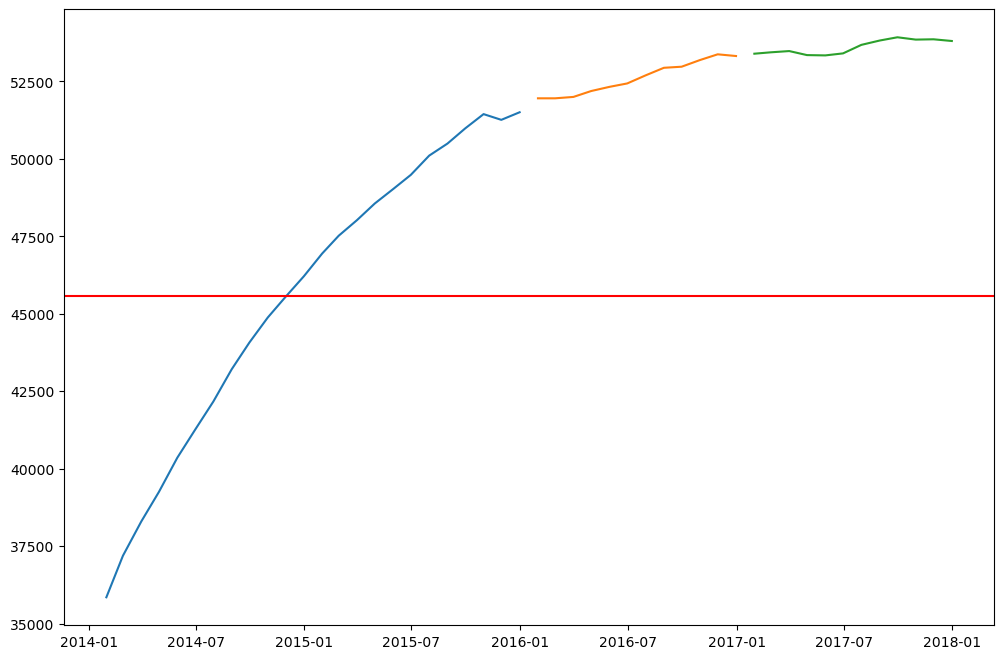

In [24]:
plt.figure(figsize=[12,8])
plt.plot(month_train)
plt.plot(month_val)
plt.plot(month_test)
plt.axhline(y=simple_average_train, color='r')
plt.show()

##  Moving Average

In [25]:
month_train = train.resample('M').amount.sum()
month_val = val.resample('M').amount.sum()
month_test = test.resample('M').amount.sum()

print (month_train.head())
print('\n\n')
print(month_val.head())
print('\n\n')
print(month_test.head())

month_invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: amount, dtype: float64



month_invoiced
2016-01-31    51955.0
2016-02-29    51955.0
2016-03-31    52000.0
2016-04-30    52190.0
2016-05-31    52325.0
Freq: M, Name: amount, dtype: float64



month_invoiced
2017-01-31    53395.0
2017-02-28    53440.0
2017-03-31    53480.0
2017-04-30    53350.0
2017-05-31    53340.0
Freq: M, Name: amount, dtype: float64


## 1 Month Rolling Average  

In [26]:
one_month_rolling = round(month_train.rolling(1).mean()[-1], 2)
one_month_rolling

51505.0

## 6 Month Rolling Average

In [27]:
six_month_rolling = round(month_train.rolling(1).mean()[-6], 2)
six_month_rolling

50105.0

## Weekly Rolling Average

In [28]:
weekly_rolling = round(month_train.rolling(4).mean()[-1], 2)
weekly_rolling

51298.75

In [29]:
preds = pd.DataFrame({'actual': month_val,
                      'one_month_rolling': one_month_rolling,
                     'six_month_rolling': six_month_rolling,
                     'weekly_rolling': weekly_rolling})

preds.head()

,actual,one_month_rolling,six_month_rolling,weekly_rolling
month_invoiced,,,,
2016-01-31,51955.0,51505.0,50105.0,51298.75
2016-02-29,51955.0,51505.0,50105.0,51298.75
2016-03-31,52000.0,51505.0,50105.0,51298.75
2016-04-30,52190.0,51505.0,50105.0,51298.75
2016-05-31,52325.0,51505.0,50105.0,51298.75


In [30]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [31]:
eval_preds(preds, 'one_month_rolling')

1222.13

In [32]:
eval_preds(preds, 'six_month_rolling')

2560.42

In [33]:
eval_preds(preds, 'weekly_rolling')

1411.79

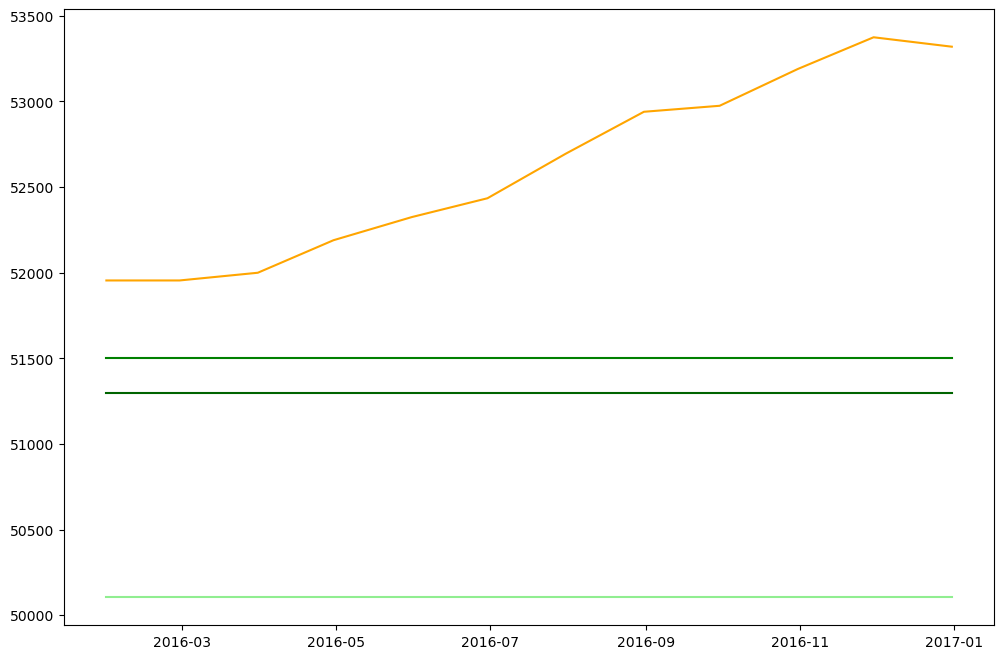

In [34]:
plt.figure(figsize=[12,8])
plt.plot(preds['actual'], c='orange')
plt.plot(preds['one_month_rolling'], c='green')
plt.plot(preds['six_month_rolling'], c='lightgreen')
plt.plot(preds['weekly_rolling'], c='darkgreen')
plt.show()

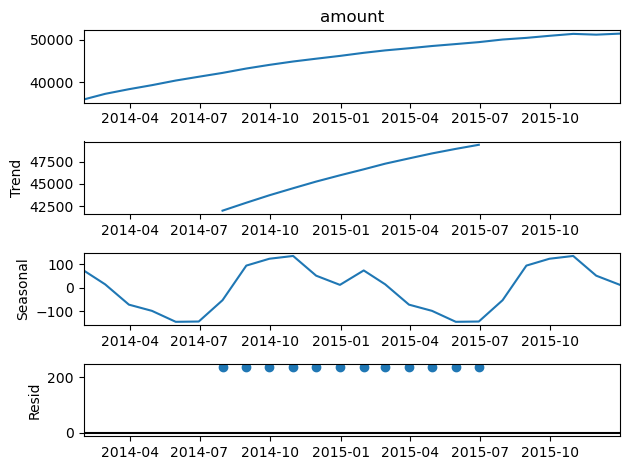

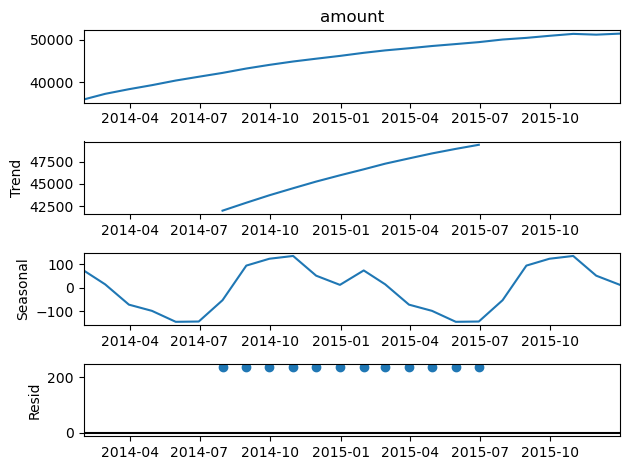

In [35]:
sm.tsa.seasonal_decompose(month_train.resample('M').mean()).plot()

## Holt's Linear Trend

In [36]:
month_train = train.resample('M').amount.sum()
month_val = val.resample('M').amount.sum()
month_test = test.resample('M').amount.sum()

month_train.head()

month_invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: amount, dtype: float64

In [37]:
month_train.tail()

month_invoiced
2015-08-31    50495.0
2015-09-30    50985.0
2015-10-31    51445.0
2015-11-30    51260.0
2015-12-31    51505.0
Freq: M, Name: amount, dtype: float64

In [38]:
model = Holt(month_train, exponential=False, damped=False)
model = model.fit(optimized=True)
yhat_values = model.predict(start = month_val.index[0],
                              end = month_val.index[-1])
preds = round(yhat_values, 2)

In [39]:
preds.head()

2016-01-31    51915.09
2016-02-29    52186.22
2016-03-31    52457.34
2016-04-30    52728.46
2016-05-31    52999.58
Freq: M, dtype: float64

In [40]:
predictions = pd.DataFrame({'actual': month_val,
                            'preds': preds})

predictions.head()

,actual,preds
2016-01-31,51955.0,51915.09
2016-02-29,51955.0,52186.22
2016-03-31,52000.0,52457.34
2016-04-30,52190.0,52728.46
2016-05-31,52325.0,52999.58


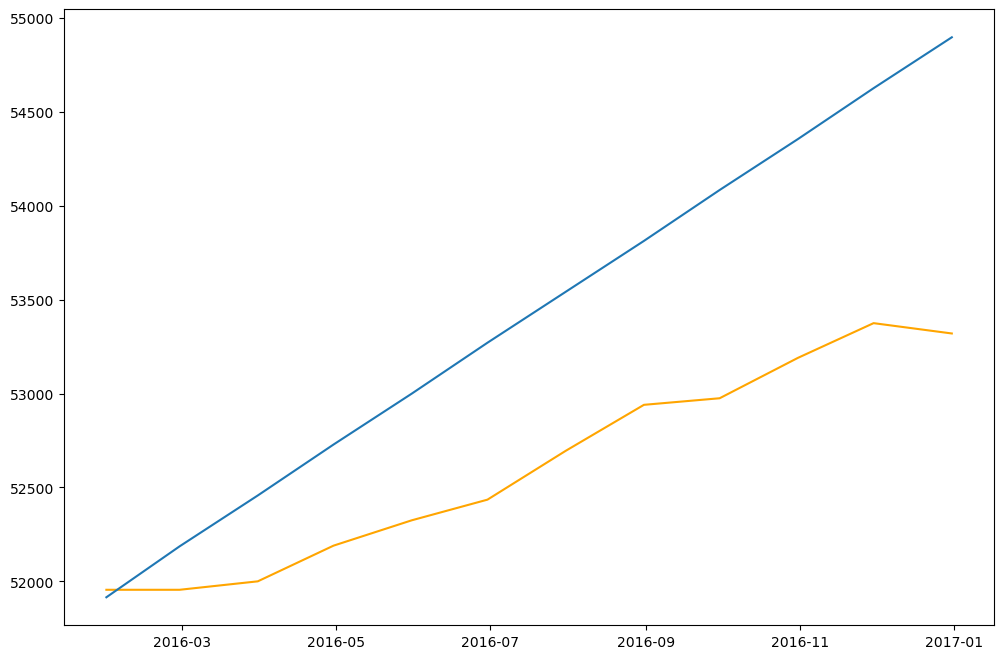

In [41]:
plt.figure(figsize=[12,8])
plt.plot(predictions['actual'], c='orange')
plt.plot(predictions['preds'])
plt.show()

In [42]:
eval_preds(predictions, 'preds')

905.0

## Holt's Seasonal Trend

In [43]:
month_train = train.resample('M').amount.sum()
month_val = val.resample('M').amount.sum()
month_test = test.resample('M').amount.sum()

month_train.head()

month_invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: amount, dtype: float64

In [44]:
month_train.tail()

month_invoiced
2015-08-31    50495.0
2015-09-30    50985.0
2015-10-31    51445.0
2015-11-30    51260.0
2015-12-31    51505.0
Freq: M, Name: amount, dtype: float64

In [45]:
month_val.head()

month_invoiced
2016-01-31    51955.0
2016-02-29    51955.0
2016-03-31    52000.0
2016-04-30    52190.0
2016-05-31    52325.0
Freq: M, Name: amount, dtype: float64

In [46]:
weekly_rolling = round(month_train.rolling(4).mean()[-1], 2)
weekly_rolling

51298.75

In [47]:
preds = pd.DataFrame({'actual': month_val,
                      'one_month_rolling': one_month_rolling,
                     'six_month_rolling': six_month_rolling,
                     'weekly_rolling': weekly_rolling})

preds.head()

,actual,one_month_rolling,six_month_rolling,weekly_rolling
month_invoiced,,,,
2016-01-31,51955.0,51505.0,50105.0,51298.75
2016-02-29,51955.0,51505.0,50105.0,51298.75
2016-03-31,52000.0,51505.0,50105.0,51298.75
2016-04-30,52190.0,51505.0,50105.0,51298.75
2016-05-31,52325.0,51505.0,50105.0,51298.75


In [48]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [49]:
eval_preds(preds, 'one_month_rolling')

1222.13

In [50]:
eval_preds(preds, 'six_month_rolling')

2560.42

## 1 Month Rolling Average

In [51]:
one_month_rolling = round(month_train.rolling(1).mean()[-1], 2)
one_month_rolling

51505.0

## 6 Month Rolling Average

In [52]:
six_month_rolling = round(month_train.rolling(1).mean()[-6], 2)
six_month_rolling

50105.0

## Weekly Rolling Average

In [53]:
weekly_rolling = round(month_train.rolling(4).mean()[-1], 2)
weekly_rolling

51298.75

In [54]:
preds = pd.DataFrame({'actual': month_val,
                      'one_month_rolling': one_month_rolling,
                     'six_month_rolling': six_month_rolling,
                     'weekly_rolling': weekly_rolling})

preds.head()

,actual,one_month_rolling,six_month_rolling,weekly_rolling
month_invoiced,,,,
2016-01-31,51955.0,51505.0,50105.0,51298.75
2016-02-29,51955.0,51505.0,50105.0,51298.75
2016-03-31,52000.0,51505.0,50105.0,51298.75
2016-04-30,52190.0,51505.0,50105.0,51298.75
2016-05-31,52325.0,51505.0,50105.0,51298.75


In [55]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [56]:
eval_preds(preds, 'one_month_rolling')

1222.13

In [57]:
eval_preds(preds, 'six_month_rolling')

2560.42

In [58]:
hst_model = ExponentialSmoothing(month_train, seasonal_periods=6, trend='add', seasonal='add').fit()

In [59]:
preds['hst'] = hst_model.forecast(month_val.shape[0])

In [60]:
preds['hst']

month_invoiced
2016-01-31    51710.527934
2016-02-29    52399.472439
2016-03-31    52792.230274
2016-04-30    53328.485837
2016-05-31    53493.380960
2016-06-30    53918.164782
2016-07-31    54031.818280
2016-08-31    54720.762784
2016-09-30    55113.520619
2016-10-31    55649.776182
2016-11-30    55814.671305
2016-12-31    56239.455127
Freq: M, Name: hst, dtype: float64

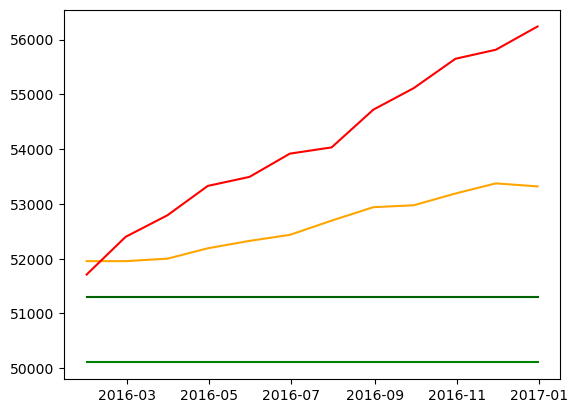

In [61]:
plt.plot(preds['actual'], c='orange')
plt.plot(preds['six_month_rolling'], c='green')
plt.plot(preds['weekly_rolling'], c='darkgreen')
plt.plot(preds['hst'], c='red')
plt.show()

In [62]:
eval_preds(preds, 'hst')

1727.31

## Based on previous year/month/etc., this is up to you.

In [63]:
month_train = train.resample('M').amount.sum()
month_val = val.resample('M').amount.sum()
month_test = test.resample('M').amount.sum()

month_train.head()

month_invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: amount, dtype: float64

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 11.1587
Iteration  1. Log joint probability =    36.3508. Improved by 25.1922.
Iteration  2. Log joint probability =    51.6591. Improved by 15.3083.
Iteration  3. Log joint probability =    69.4933. Improved by 17.8342.
Iteration  4. Log joint probability =    78.6001. Improved by 9.10678.
Iteration  5. Log joint probability =    80.2496. Improved by 1.64952.
Iteration  6. Log joint probability =    80.4285. Improved by 0.178912.
Iteration  7. Log joint probability =    80.5287. Improved by 0.100124.
Iteration  8. Log joint probability =    80.6975. Improved by 0.168865.
Iteration  9. Log joint probability =    80.9142. Improved by 0.216683.
Iteration 10. Log joint probability =     81.013. Improved by 0.098803.
Iteration 11. Log joint probability =     81.116. Improved by 0.10303.
Iteration 12. Log joint probability =    81.3195. Improved by 0.203507.
Iteration 13. Log joint probability =     81.457. Improved by 0.13746.
Iteration 14. Log joint probab

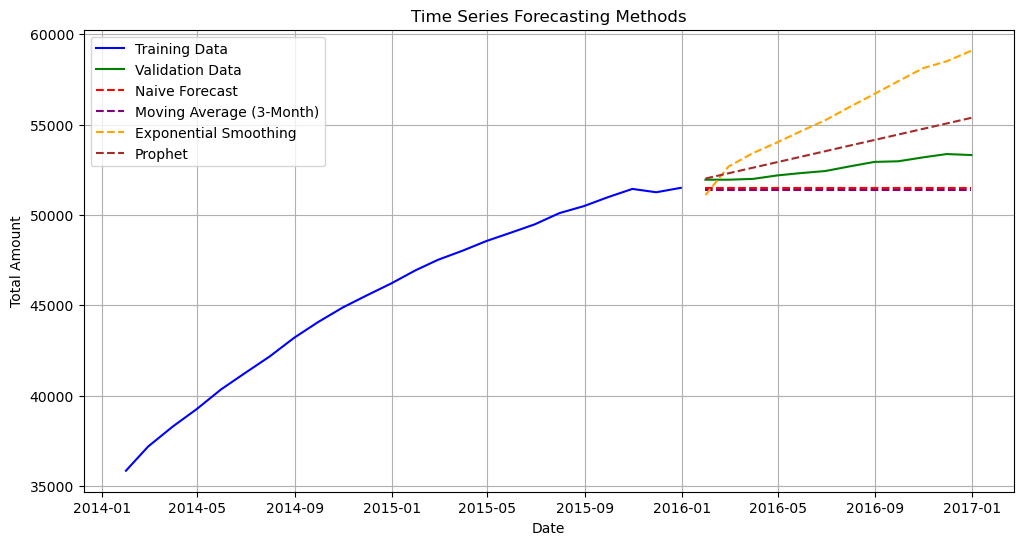

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

# Naive Forecasting
naive_forecast = month_train.iloc[-1]
naive_forecast = pd.Series(naive_forecast, index=month_val.index)

# Moving Average
n = 3  # You can adjust this window size
moving_average = month_train.rolling(window=n).mean().iloc[-1]
moving_average = pd.Series(moving_average, index=month_val.index)

# Exponential Smoothing
model = ExponentialSmoothing(month_train, trend='add', seasonal='add', seasonal_periods=12) # year
model_fit = model.fit()
exp_smoothing_forecast = model_fit.forecast(len(month_val))

# Prophet
prophet_df = pd.DataFrame({'ds': month_train.index, 'y': month_train.values})
model_prophet = Prophet()
model_prophet.fit(prophet_df)
future = model_prophet.make_future_dataframe(periods=len(month_val), freq='M')
forecast_prophet = model_prophet.predict(future)
forecast_prophet = forecast_prophet.set_index('ds')

# Plotting the forecasts
plt.figure(figsize=(12, 6))
plt.plot(month_train.index, month_train.values, label='Training Data', color='blue')
plt.plot(month_val.index, month_val.values, label='Validation Data', color='green')
plt.plot(naive_forecast.index, naive_forecast.values, label='Naive Forecast', color='red', linestyle='--')
plt.plot(moving_average.index, moving_average.values, label=f'Moving Average ({n}-Month)', color='purple', linestyle='--')
plt.plot(month_val.index, exp_smoothing_forecast, label='Exponential Smoothing', color='orange', linestyle='--')
plt.plot(forecast_prophet.index[-len(month_val):], forecast_prophet['yhat'][-len(month_val):].values, label='Prophet', color='brown', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Time Series Forecasting Methods')
plt.legend()
plt.grid(True)

# Evaluation (you can use any appropriate metrics like RMSE, MAE, etc.)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

naive_rmse = np.sqrt(mean_squared_error(month_val, naive_forecast))
naive_mae = mean_absolute_error(month_val, naive_forecast)
moving_average_rmse = np.sqrt(mean_squared_error(month_val, moving_average))
moving_average_mae = mean_absolute_error(month_val, moving_average)
exp_smoothing_rmse = np.sqrt(mean_squared_error(month_val, exp_smoothing_forecast))
exp_smoothing_mae = mean_absolute_error(month_val, exp_smoothing_forecast)
prophet_rmse = np.sqrt(mean_squared_error(month_val, forecast_prophet['yhat'][-len(month_val):].values))
prophet_mae = mean_absolute_error(month_val, forecast_prophet['yhat'][-len(month_val):].values)

print(f'Naive RMSE: {naive_rmse:.2f}, MAE: {naive_mae:.2f}')
print(f'Moving Average ({n}-Month) RMSE: {moving_average_rmse:.2f}, MAE: {moving_average_mae:.2f}')
print(f'Exponential Smoothing RMSE: {exp_smoothing_rmse:.2f}, MAE: {exp_smoothing_mae:.2f}')
print(f'Prophet RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}')

plt.show()


# Bonus: 

### 1. Using the store item demand data, create a forecast of sales_total and quantity for 2018 using the Previous Cycle approach. .

### 2. Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet. 3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). 4. Plot the 2018 monthly sales predictions.